# Import Necessary Library

In [1]:
import pandas as pd
import numpy as np

import os
import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (20,8)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Prepare Database

In [1]:
folder_path = './data'
dfs = []

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    df = pd.read_csv(file_path)
    dfs.append(df)

## Create SQL Table

In [2]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('perqara.db')
cur = conn.cursor()

In [5]:
with open('create.sql', 'r') as f:
    sql_script = f.read()
    
cur.executescript(sql_script)
conn.commit()

In [6]:
# show the table names
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cur.fetchall()

for table in tables:
    print(table[0])

customers
geolocation
order_items
payments
reviews
orders
category_name
products
seller


In [7]:
file_dict = {}

for i, filename in enumerate(os.listdir(folder_path)):
    file_path = os.path.join(folder_path, filename)
    file_dict[i] = file_path

file_dict

{0: './data\\customers_dataset.csv',
 1: './data\\geolocation_dataset.csv',
 2: './data\\orders_dataset.csv',
 3: './data\\order_items_dataset.csv',
 4: './data\\order_payments_dataset.csv',
 5: './data\\order_reviews_dataset.csv',
 6: './data\\products_dataset.csv',
 7: './data\\product_category_name_translation.csv',
 8: './data\\sellers_dataset.csv'}

In [8]:
table = ['customers', 'geolocation', 'orders', 'order_items', 'payments', 'reviews', 'products', 'category_name', 'seller']

for i, name in enumerate(table):
    dfs[i].to_sql(name, conn, if_exists='replace', index=False)
    cur.execute(f'SELECT COUNT(*) FROM {name}')
    num_rows = cur.fetchone()[0]
    print(f'Column {name} has {num_rows} rows')

Column customers has 99441 rows
Column geolocation has 1000163 rows
Column orders has 99441 rows
Column order_items has 112650 rows
Column payments has 103886 rows
Column reviews has 99224 rows
Column products has 32951 rows
Column category_name has 71 rows
Column seller has 3095 rows


In [9]:
updates = ["""
    UPDATE orders
    SET      
        order_purchase_timestamp = DATE(order_purchase_timestamp),
        order_approved_at = DATE(order_approved_at),
        order_delivered_carrier_date = DATE(order_delivered_carrier_date),
        order_delivered_customer_date = DATE(order_delivered_customer_date),
        order_estimated_delivery_date = DATE(order_estimated_delivery_date)     
""",
    """
    UPDATE order_items
    SET shipping_limit_date = DATE(shipping_limit_date)
""",
"""
    UPDATE reviews
    SET review_creation_date = DATE(review_creation_date)
"""
]

for update in updates:
    cur.execute(update)
    conn.commit()

# EDA

In [2]:
def read(query):
    cur.execute(query)
    rows = cur.fetchall()
    
    # get column name from the query
    columns = [description[0] for description in cur.description]

    # create dataframe from the query
    df = pd.DataFrame(rows, columns=columns)
    return df

In [3]:
def bar_chart(data, x, y, detail=True, hue=None, title=None):
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(data=data, x=x, y=y, hue=hue, palette='mako')
    if detail:
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}',
                        (p.get_x() + p.get_width()/2., p.get_height()),
                        ha='center', va='baseline',
                        fontsize=12, color='black', xytext=(0, 5),
                        textcoords='offset points'
                        )
            
    plt.title(title, fontsize=20, fontweight='bold')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [4]:
def line_plot(data, x, y, hue=None, title=None):
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=data, x=x, y=y, hue=hue)
    plt.title(title, fontsize=20, fontweight='bold')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [5]:
cust = read('SELECT customer_id, COUNT(1) num_order FROM orders GROUP BY 1')
order = read('SELECT DISTINCT(order_id) FROM orders')

print(f'There are {len(cust)} customers_id that placed an order, which the total number of orders is {len(order)}.')

There are 99441 customers_id that placed an order, which the total number of orders is 99441.


In [105]:
abc = read("""
SELECT AVG(num_orders) abc
FROM (
    SELECT customer_unique_id, COUNT(*) num_orders
    FROM customers
    GROUP BY 1
)
""")

avg = abc.loc[0, 'abc']
print(f'The average of the number of order is {avg}')

The average of the number of order is 1.0348089410589412


In [36]:
read("""
SELECT
    c.customer_unique_id,
    SUM(p.payment_sequential) payment_sequential,
    SUM(p.payment_installments) payment_installments,
    SUM(p.payment_value) payment_value
FROM payments p
JOIN orders o ON o.order_id = p.order_id
JOIN customers c ON c.customer_id = o.customer_id
GROUP BY 1
""")

,customer_unique_id,payment_sequential,payment_installments,payment_value
0,0000366f3b9a7992bf8c76cfdf3221e2,1,8,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1,27.19
2,0000f46a3911fa3c0805444483337064,1,8,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,1,4,43.62
4,0004aac84e0df4da2b147fca70cf8255,1,6,196.89
...,...,...,...,...
96090,fffcf5a5ff07b0908bd4e2dbc735a684,1,10,2067.42
96091,fffea47cd6d3cc0a88bd621562a9d061,1,1,84.58
96092,ffff371b4d645b6ecea244b27531430a,1,1,112.46
96093,ffff5962728ec6157033ef9805bacc48,1,5,133.69


In [13]:
read('''
select order_id, count(1) qty from
    (select o.order_id, p.payment_type, count(8) num_pay 
    from payments p join orders o on p.order_id = o.order_id 
    group by 1, 2 
    order by 1)
group by 1
having qty > 1
''')

,order_id,qty
0,0016dfedd97fc2950e388d2971d718c7,2
1,009ac365164f8e06f59d18a08045f6c4,2
2,00b4a910f64f24dbcac04fe54088a443,2
3,00bd50cdd31bd22e9081e6e2d5b3577b,2
4,00c405bd71187154a7846862f585a9d4,2
...,...,...
2241,ff1f8f328e5a59ac754240b6dd31bcb4,2
2242,ff20ee702706d9e407a34de9fe2ff768,2
2243,ff7400d904161b62b6e830b3988f5cbd,2
2244,ffa1dd97810de91a03abd7bd76d2fed1,2


In [31]:
unique_cust = read('SELECT DISTINCT(customer_unique_id) FROM customers')
orders = read("""
SELECT customer_unique_id, COUNT(1) num_order
FROM orders o 
JOIN customers c ON o.customer_id = c.customer_id
GROUP BY 1
HAVING num_order > 1
""")

print(f'Total unique customers are {len(unique_cust)}, of which {len(orders)} customers have placed more than one order.')

Total unique customers are 96096, of which 2997 customers have placed more than one order.


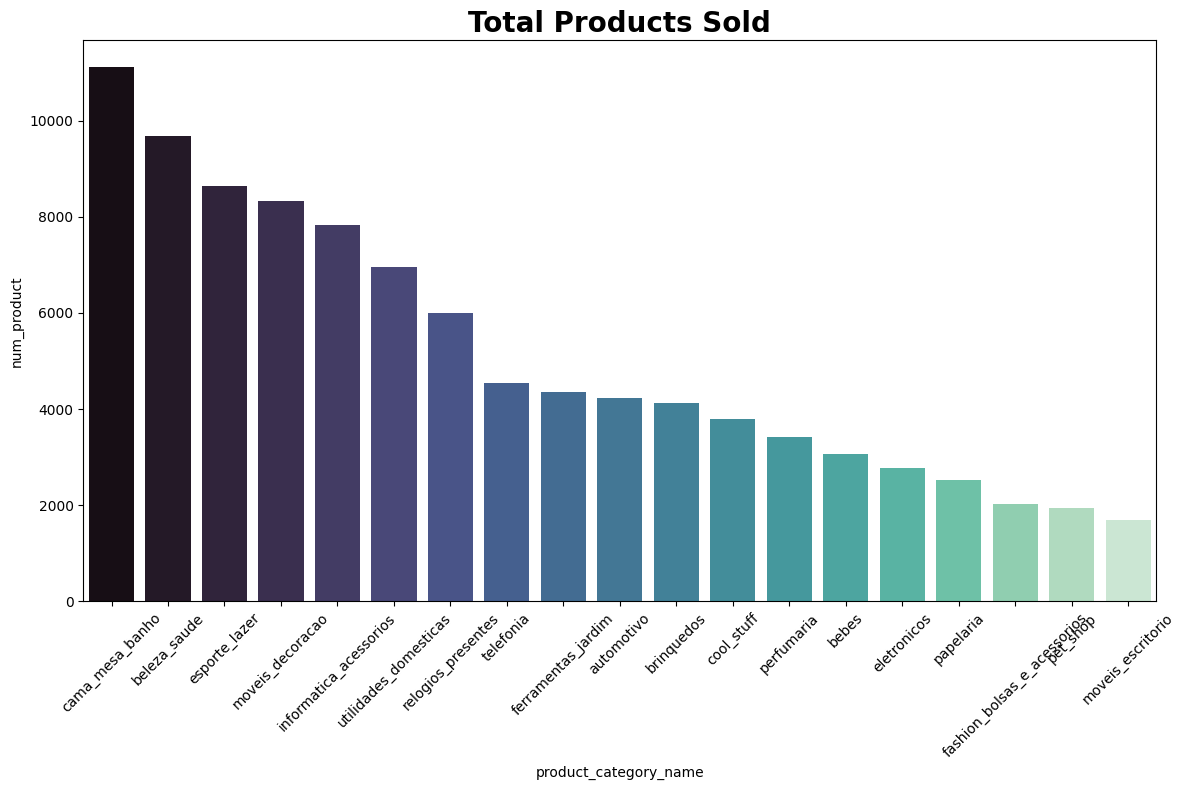

In [12]:
query = """
SELECT p.product_category_name, COUNT(*) num_product
FROM order_items oi
JOIN products p
    ON oi.product_id = p.product_id
GROUP BY 1
ORDER BY 2 DESC
"""

data = read(query)
bar_chart(data=data.head(20), x='product_category_name', y='num_product', detail=False, title='Total Products Sold')

To capitalize on this trend, it is recommended to focus marketing efforts on the top-selling categories, such as bedding, beauty, and sports products. Additionally, for the lower-performing categories, consider conducting targeted promotions or improving product offerings to boost sales in those areas. Understanding the drivers behind high-performing categories can also inform strategies for enhancing customer engagement and encouraging repeat purchases across other product lines.

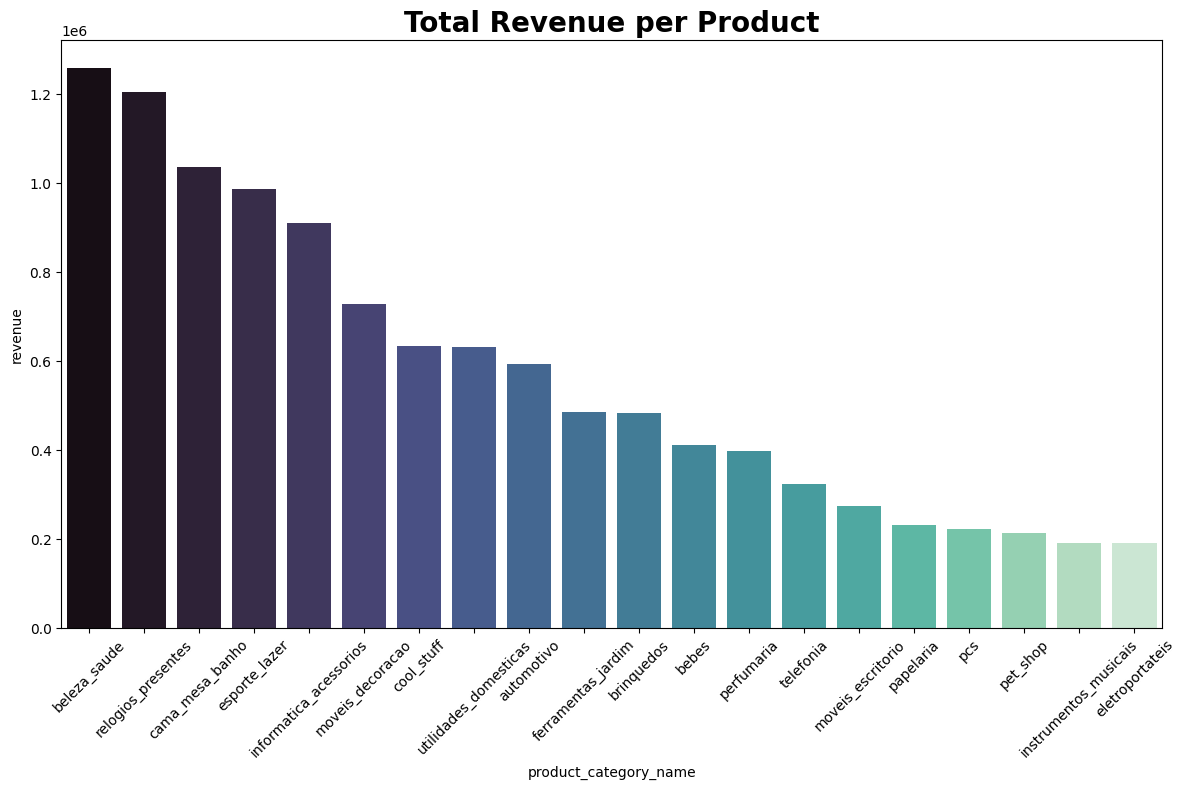

In [27]:
query = """
SELECT p.product_category_name, SUM(oi.price) revenue
FROM order_items oi
JOIN products p
    ON oi.product_id = p.product_id
GROUP BY 1
ORDER BY 2 DESC
"""

data = read(query)
bar_chart(data.head(20), x='product_category_name', y='revenue', detail=False, title='Total Revenue per Product')

To maximize revenue, it is recommended to **concentrate marketing resources** on the top-performing categories, particularly beauty and health, watches and gifts, and bedding products. Additionally, consider developing strategies to boost sales in lower-performing categories, such as musical instruments and small appliances, through targeted promotions, product diversification, or partnerships with influencers in relevant niches. Understanding customer preferences in high-revenue categories can also help enhance offerings in similar or complementary product lines.

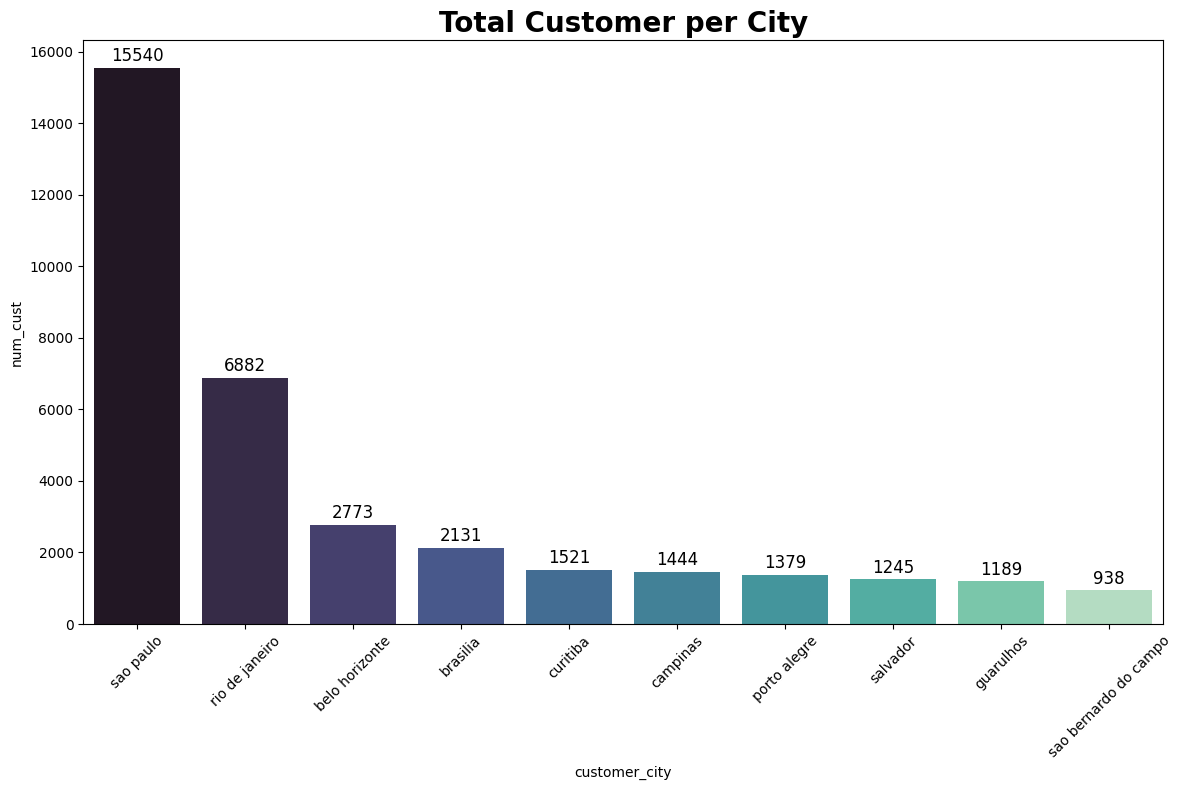

In [5]:
data = read('''
     SELECT customer_city, COUNT(1) num_cust 
     FROM customers 
     GROUP BY 1 
     ORDER BY 2 DESC 
     ''')

bar_chart(data.head(10), x='customer_city', y='num_cust', title='Total Customer per City')

Given São Paulo's substantial customer base, it is recommended to **prioritize marketing** efforts and resource allocation in this city to further strengthen customer engagement and loyalty. Additionally, **targeted campaigns** in Rio de Janeiro could help capitalize on its large customer base. For cities with fewer customers, consider localized promotions, partnerships, or expanding distribution channels to increase market penetration and attract new customers. Understanding regional preferences and tailoring product offerings to meet local demands can further enhance customer acquisition and retention across different cities.

In [25]:
read("""
     WITH city_cust AS (
          SELECT customer_city, COUNT(1) AS num_cust 
          FROM customers 
          GROUP BY customer_city 
          ORDER BY num_cust DESC 
          LIMIT 5
     ),
     product_revenue AS (
          SELECT 
               c.customer_city, 
               p.product_category_name, 
               SUM(oi.price) AS revenue
          FROM order_items oi
          JOIN products p 
               ON oi.product_id = p.product_id
          JOIN orders o 
               ON oi.order_id = o.order_id
          JOIN customers c 
               ON o.customer_id = c.customer_id 
          GROUP BY 
               c.customer_city, 
               p.product_category_name
          HAVING c.customer_city IN (
               SELECT customer_city FROM city_cust)
               AND o.order_status NOT IN ('canceled', 'unavailable')
     ),
     ranked_products AS (
          SELECT 
               customer_city, 
               product_category_name, 
               revenue,
               ROW_NUMBER() OVER (PARTITION BY customer_city ORDER BY revenue DESC) AS rank
          FROM 
               product_revenue
     )
     SELECT 
          customer_city, 
          product_category_name, 
          revenue
     FROM 
          ranked_products
     WHERE 
          rank <= 5
     ORDER BY 
          customer_city, 
          rank
""")

,customer_city,product_category_name,revenue
0,belo horizonte,beleza_saude,33973.90
1,belo horizonte,cama_mesa_banho,31974.78
2,belo horizonte,relogios_presentes,25148.01
3,belo horizonte,informatica_acessorios,25130.38
4,belo horizonte,esporte_lazer,23333.33
5,brasilia,relogios_presentes,32730.37
6,brasilia,beleza_saude,29862.82
7,brasilia,informatica_acessorios,25029.33
8,brasilia,esporte_lazer,22757.38
9,brasilia,automotivo,17290.04


- São Paulo leads in all categories, with the "beleza_saude" (beauty and health) category generating the highest revenue of 189,361.87, followed closely by "cama_mesa_banho" (bedding, table, and bath) at 170,705.41 and "relogios_presentes" (watches and gifts) at 165,897.46. The high revenue figures in São Paulo indicate a strong market presence, particularly in beauty, bedding, and watches. Invest in localized marketing strategies and customer loyalty programs in São Paulo to maximize revenue.

- Rio de Janeiro follows with strong performance in "relogios_presentes" (93,028.74) and "beleza_saude" (86,558.34). Given its strong performance, particularly in watches and beauty products, consider targeted advertising and promotions in Rio de Janeiro to capitalize on existing demand.

In [46]:
import numpy as np

data = read('SELECT order_status, COUNT(1) num_order FROM orders GROUP BY 1')

data['percent'] = data['num_order']/np.sum(data['num_order']) * 100
data

,order_status,num_order,percent
0,approved,2,0.002011
1,canceled,625,0.628513
2,created,5,0.005028
3,delivered,96478,97.020344
4,invoiced,314,0.315765
5,processing,301,0.302692
6,shipped,1107,1.113223
7,unavailable,609,0.612423


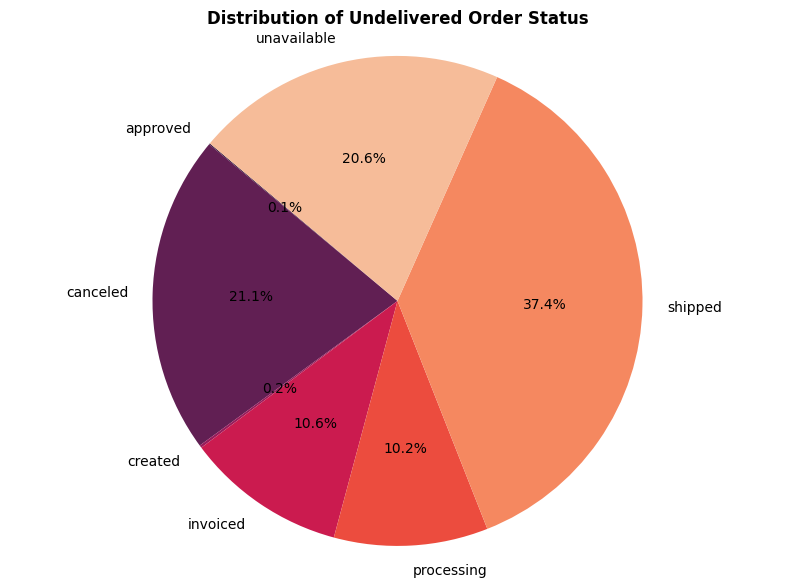

In [52]:
data = read('SELECT order_status, COUNT(1) num_order FROM orders GROUP BY 1 HAVING order_status != "delivered"')

# Create the pie chart
plt.figure(figsize=(10, 7))
colors = sns.color_palette("rocket", len(data))

plt.pie(data['num_order'], labels=data['order_status'], autopct='%1.1f%%', startangle=140, colors=colors)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')
plt.title('Distribution of Undelivered Order Status', fontweight='bold')
plt.show()

The high percentage of orders stuck in the "shipped" status suggests a potential bottleneck in the delivery process. It is recommended to conduct a thorough **review of the logistics** and delivery operations to identify and address any inefficiencies or delays. For the significant number of canceled orders, analyzing the reasons behind cancellations could provide insights for improving customer satisfaction and reducing order cancellations in the future. Additionally, streamlining the approval and invoicing processes could help expedite order fulfillment and enhance the overall customer experience.

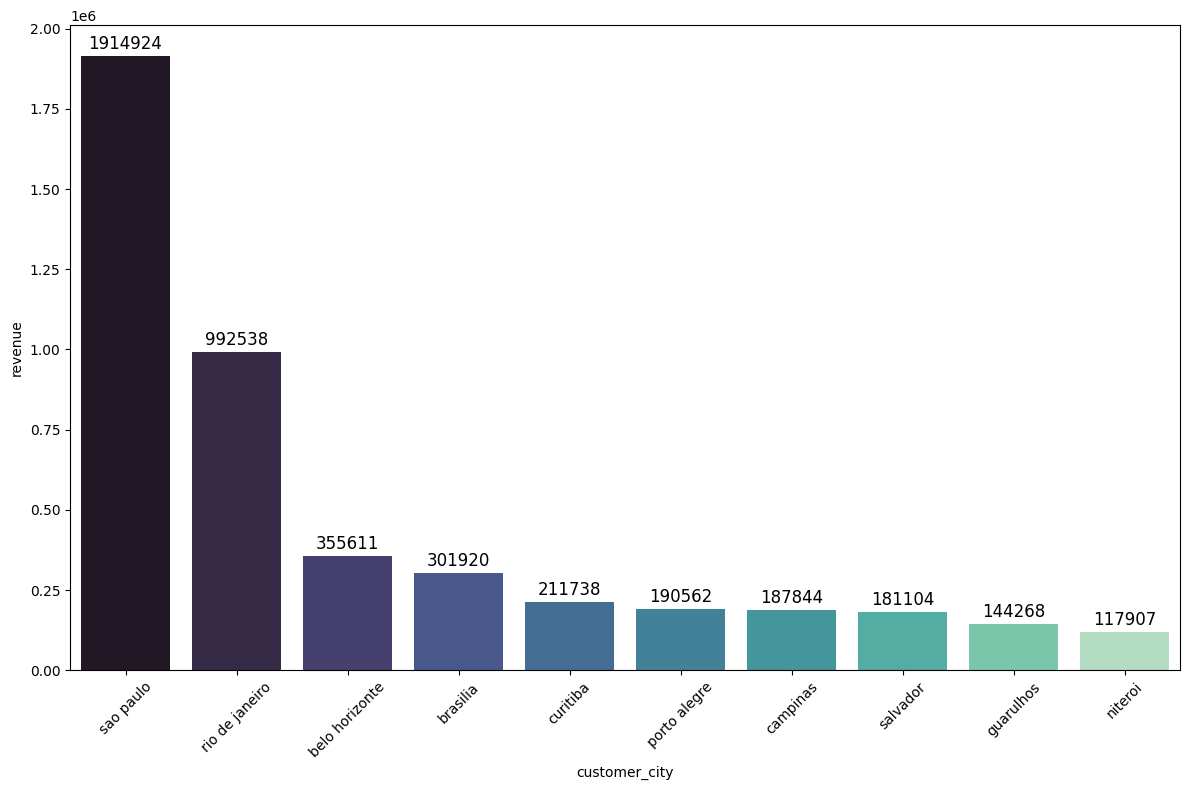

In [22]:
q = '''
SELECT c.customer_city, SUM(oi.price) revenue
FROM order_items oi
JOIN orders o ON o.order_id = oi.order_id
JOIN customers c ON c.customer_id = o.customer_id
GROUP BY 1
HAVING order_status NOT IN ('canceled', 'unavailable')
ORDER BY 2 DESC
LIMIT 10
'''

bar_chart(read(q), 'customer_city', 'revenue')

Given São Paulo's dominant contribution to the revenue, it is recommended to prioritize marketing and sales efforts in this city, possibly by offering exclusive deals or localized advertising campaigns to further increase sales. Additionally, exploring opportunities to increase market penetration in other high-performing cities like Rio de Janeiro could be beneficial. For cities with lower revenue contributions, targeted promotions, customer engagement activities, and possibly revising product availability could help improve revenue performance in these regions.

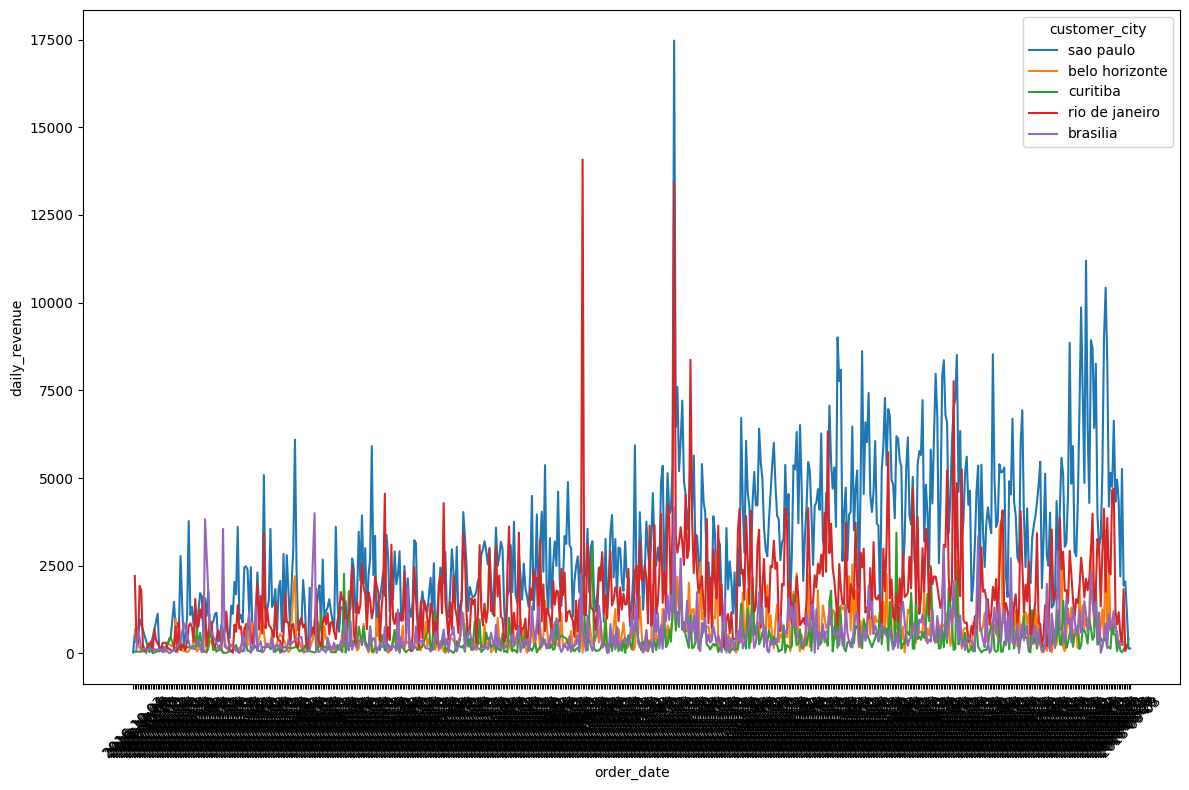

In [11]:
query = '''
WITH topCity AS (
    SELECT customer_city, COUNT(1) AS num_cust
    FROM customers
    GROUP BY customer_city
    ORDER BY num_cust DESC
    LIMIT 5
),
city_revenue AS (
    SELECT 
        o.order_id,  
        c.customer_city,
        o.order_purchase_timestamp AS order_date,
        SUM(oi.price) AS revenue
    FROM order_items oi
    JOIN orders o ON oi.order_id = o.order_id
    JOIN customers c ON o.customer_id = c.customer_id
    WHERE c.customer_city IN (SELECT customer_city FROM topCity)
      AND o.order_status NOT IN ('canceled', 'unavailable')
    GROUP BY o.order_id, c.customer_city, order_date
)
SELECT
    cr.order_date,
    cr.customer_city,
    SUM(cr.revenue) AS daily_revenue
FROM city_revenue cr
GROUP BY cr.order_date, cr.customer_city
ORDER BY cr.order_date, cr.customer_city;
'''

line_plot(read(query), 'order_date', 'daily_revenue', 'customer_city')

The frequent revenue spikes in São Paulo suggest that this city experiences periodic high-demand events, possibly tied to specific promotions, holidays, or marketing campaigns. To capitalize on this trend, it's recommended to analyze the timing and context of these spikes to replicate similar strategies in other cities, particularly in Rio de Janeiro, which already shows potential for higher sales. Additionally, maintaining a strong inventory and readiness during these peak times in São Paulo could further maximize revenue. For the other cities, localized marketing efforts could help stimulate similar spikes in demand, leveraging the insights gained from São Paulo's purchasing behavior.

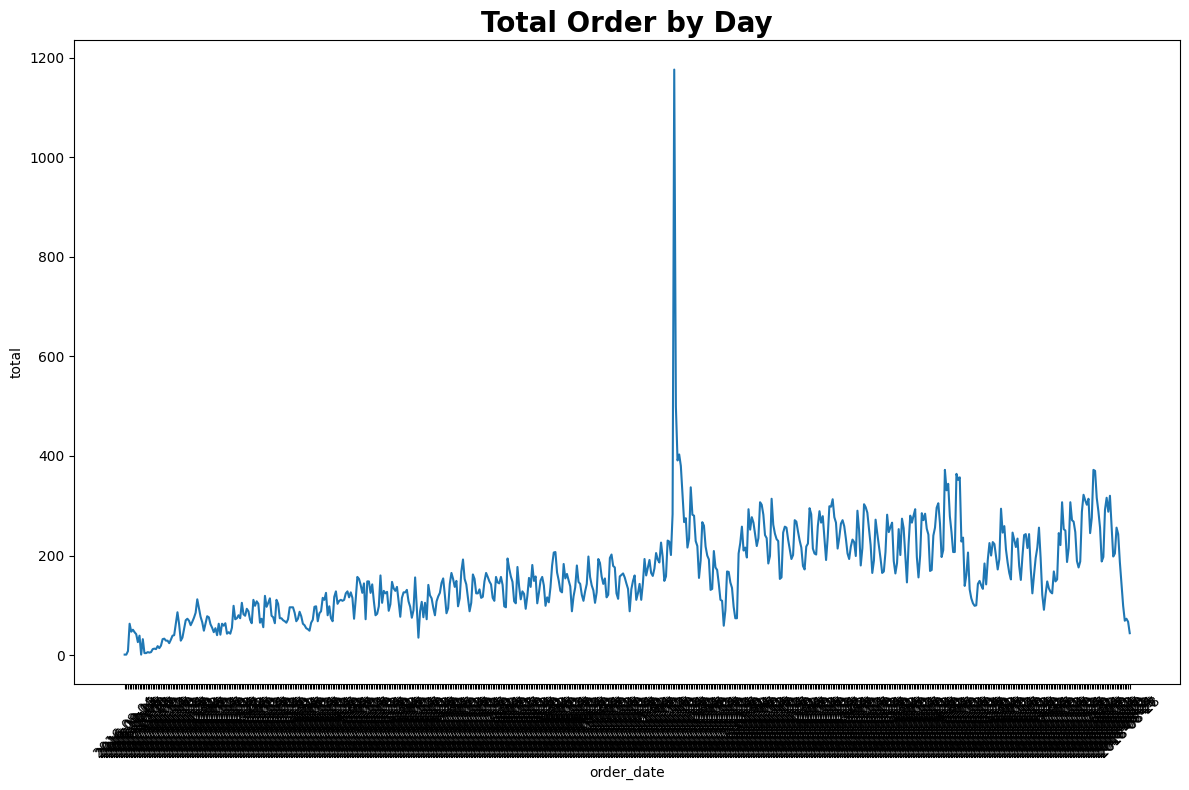

In [27]:
data = read("""
SELECT order_purchase_timestamp order_date, COUNT(*) total
FROM orders
GROUP BY 1
HAVING order_status NOT IN ('canceled', 'unavailable')
ORDER BY 1            
""")

line_plot(data, 'order_date', 'total', title='Total Order by Day')

The sharp spike in total orders suggests a specific event or promotion that drove an unusual surge in demand. To replicate this success, it is recommended to identify the cause of this spike and consider implementing similar strategies at regular intervals, especially during key shopping seasons. Additionally, since the order volume remains elevated after the spike, it might be beneficial to ensure that inventory and logistics are optimized to handle these fluctuations in demand. Understanding the factors that led to this surge could also help in planning future campaigns, ensuring sustained growth in order volume over time.

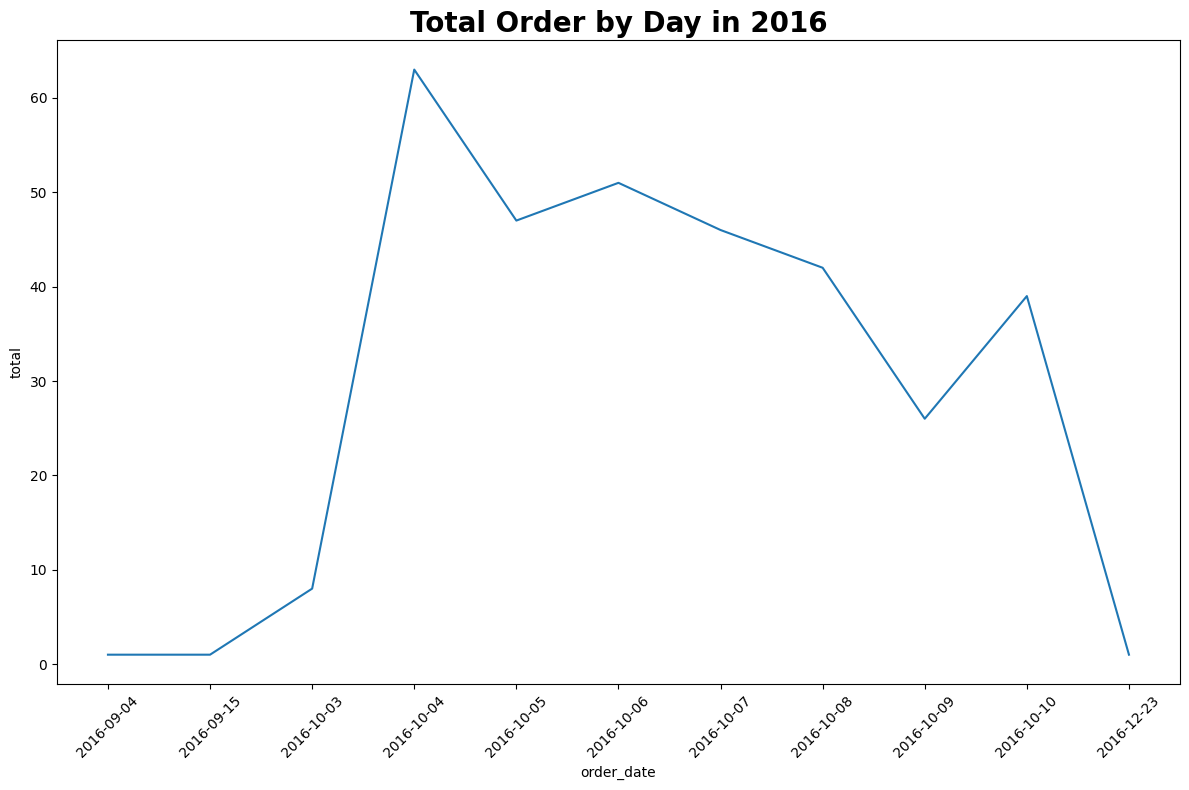

In [28]:
data = read("""
SELECT order_purchase_timestamp order_date, COUNT(*) total
FROM orders
GROUP BY 1
HAVING order_date LIKE '2016%' AND order_status NOT IN ('canceled', 'unavailable')
ORDER BY 1            
""")

line_plot(data, 'order_date', 'total', title='Total Order by Day in 2016')

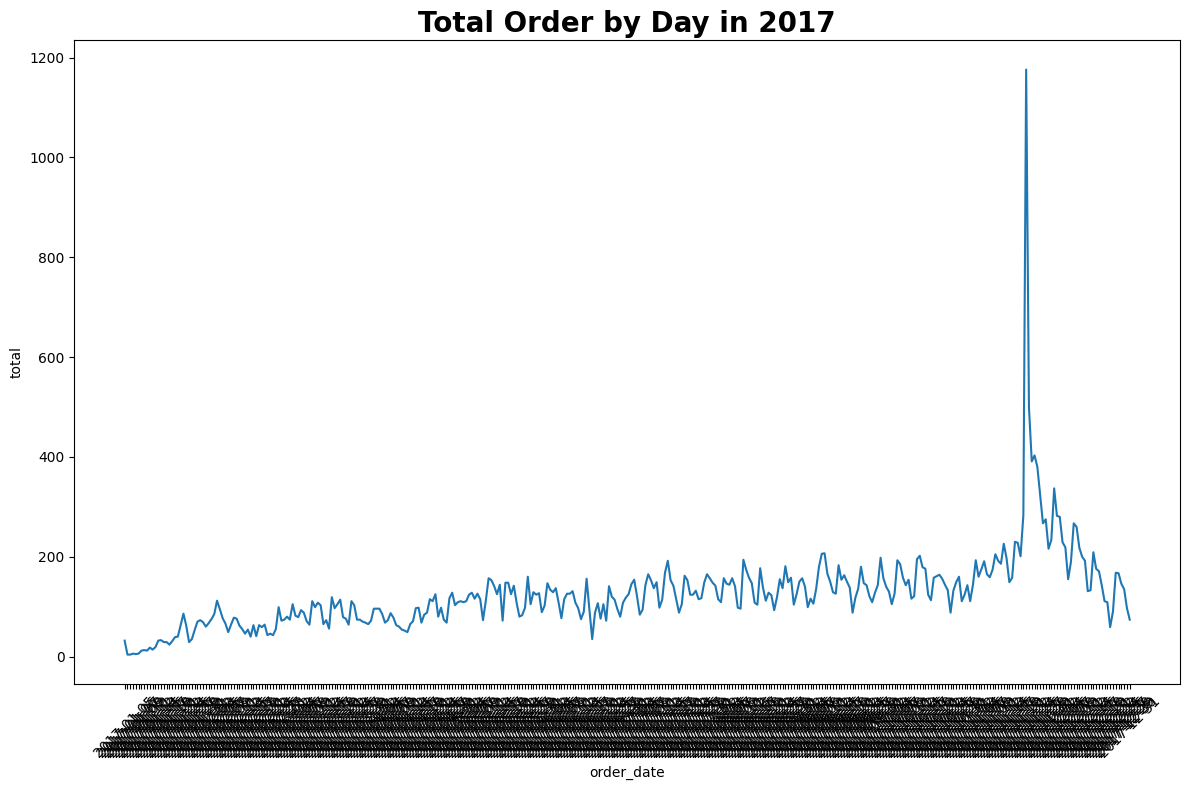

In [30]:
data = read("""
SELECT order_purchase_timestamp order_date, COUNT(*) total
FROM orders
GROUP BY 1
HAVING order_date LIKE '2017%' AND order_status NOT IN ('canceled', 'unavailable')
ORDER BY 1            
""")

line_plot(data, 'order_date', 'total', title='Total Order by Day in 2017')

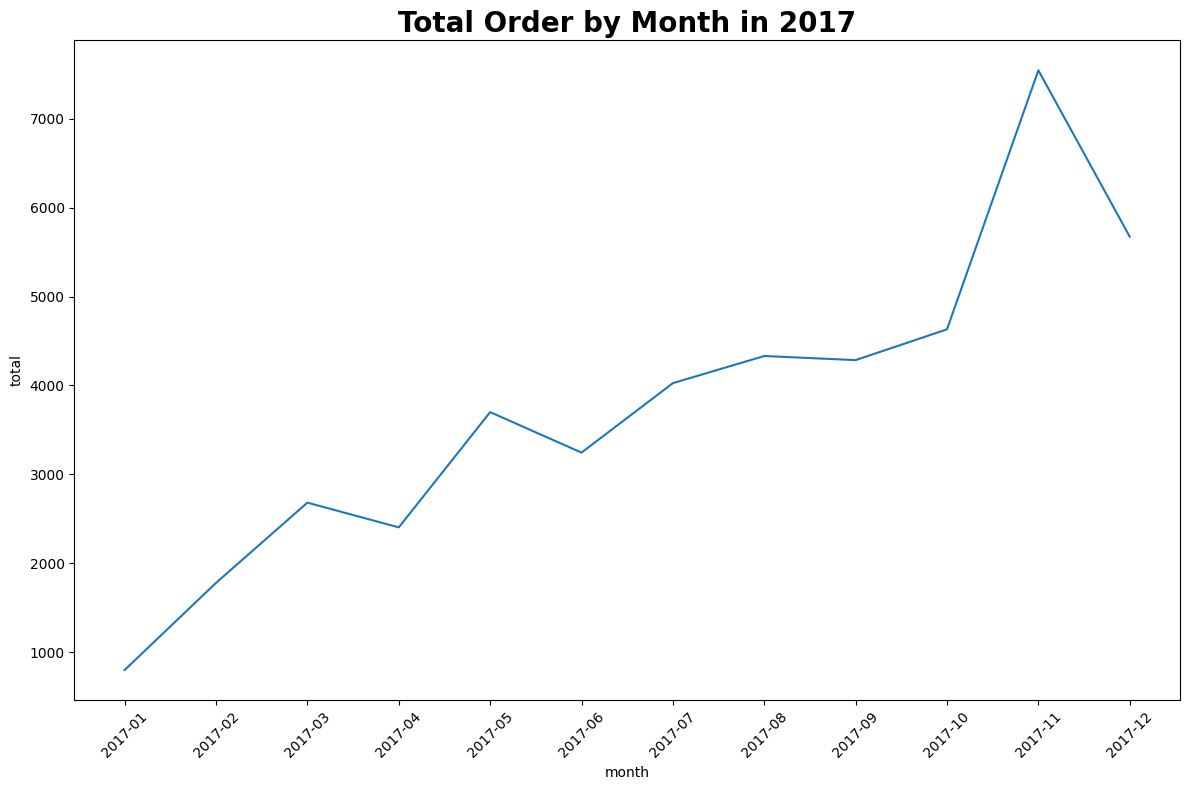

In [31]:
data = read("""
SELECT strftime('%Y-%m', order_purchase_timestamp) AS month,
       COUNT(*) AS total
FROM orders
WHERE order_purchase_timestamp LIKE '2017%'
GROUP BY month
ORDER BY month
""")

line_plot(data, 'month', 'total', title='Total Order by Month in 2017')

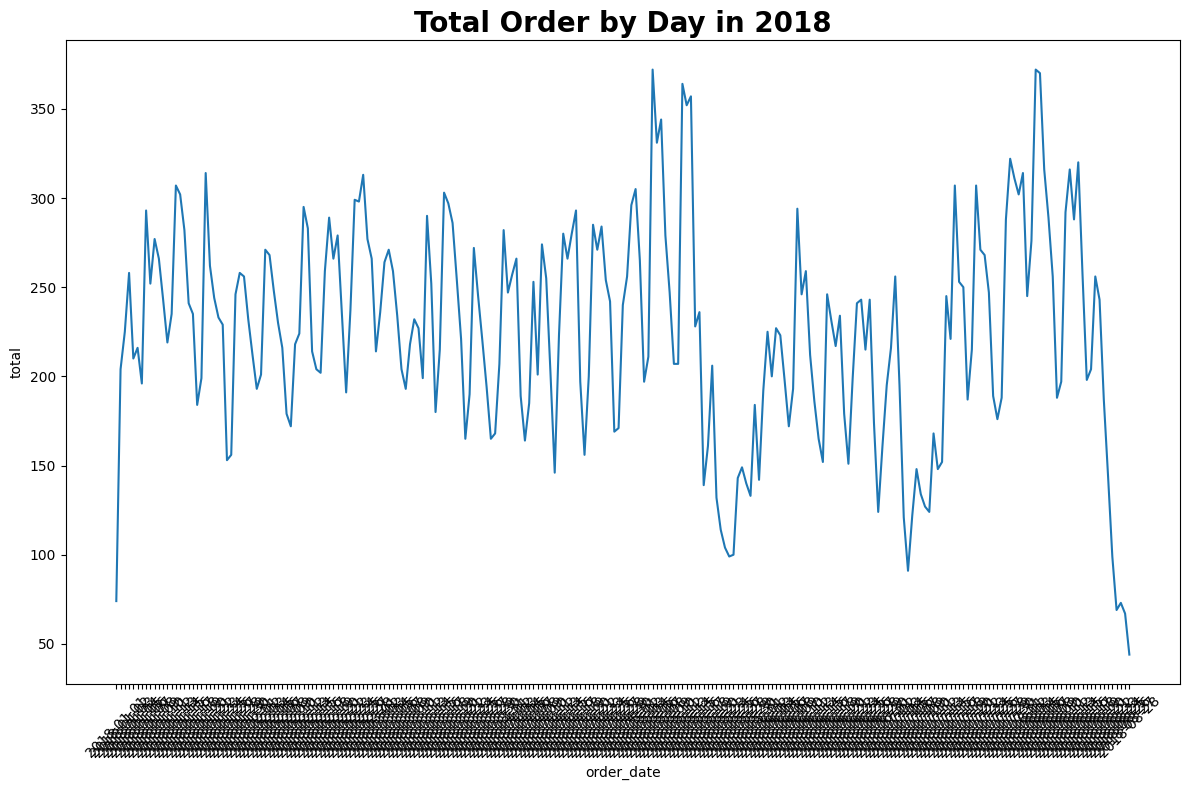

In [32]:
data = read("""
SELECT order_purchase_timestamp order_date, COUNT(*) total
FROM orders
GROUP BY 1
HAVING order_date LIKE '2018%' AND order_status NOT IN ('canceled', 'unavailable')
ORDER BY 1            
""")

line_plot(data, 'order_date', 'total', title='Total Order by Day in 2018')

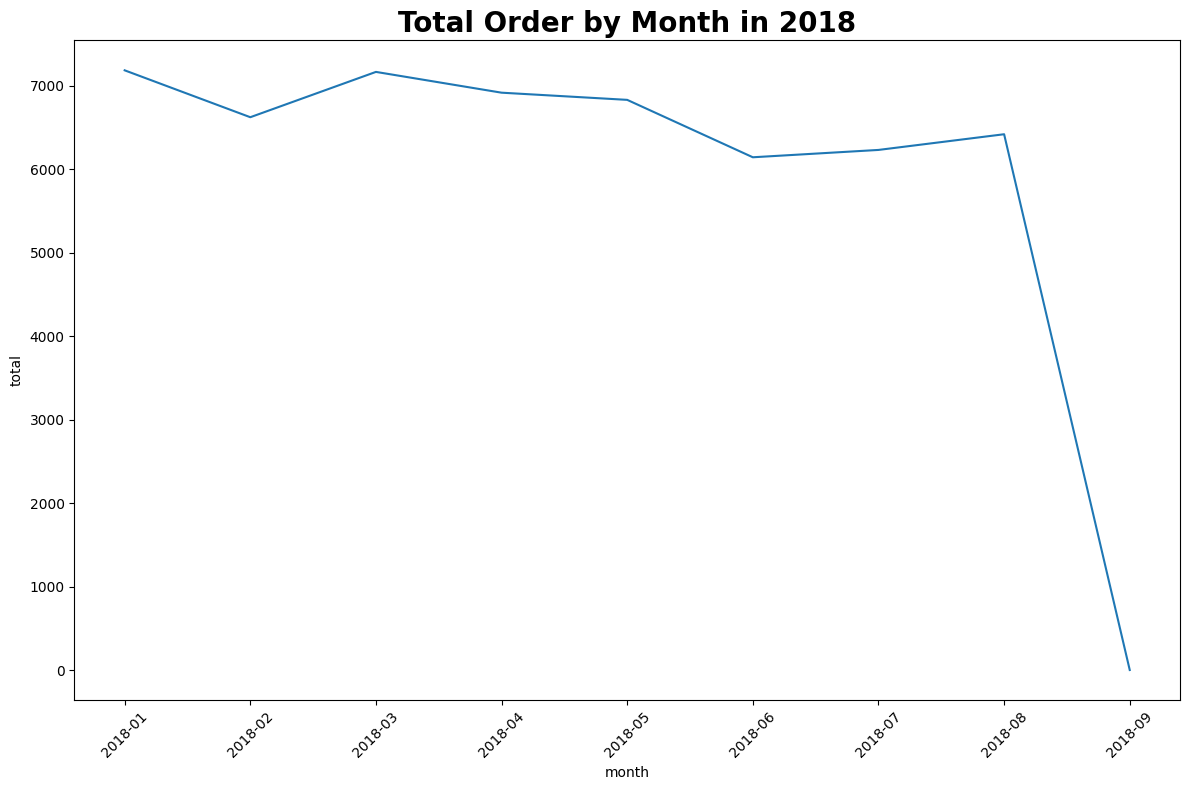

In [33]:
data = read("""
SELECT strftime('%Y-%m', order_purchase_timestamp) AS month,
       COUNT(*) AS total
FROM orders
WHERE order_purchase_timestamp LIKE '2018%' AND order_status NOT IN ('canceled', 'unavailable')
GROUP BY month
ORDER BY month;
""")

line_plot(data, 'month', 'total', title='Total Order by Month in 2018')

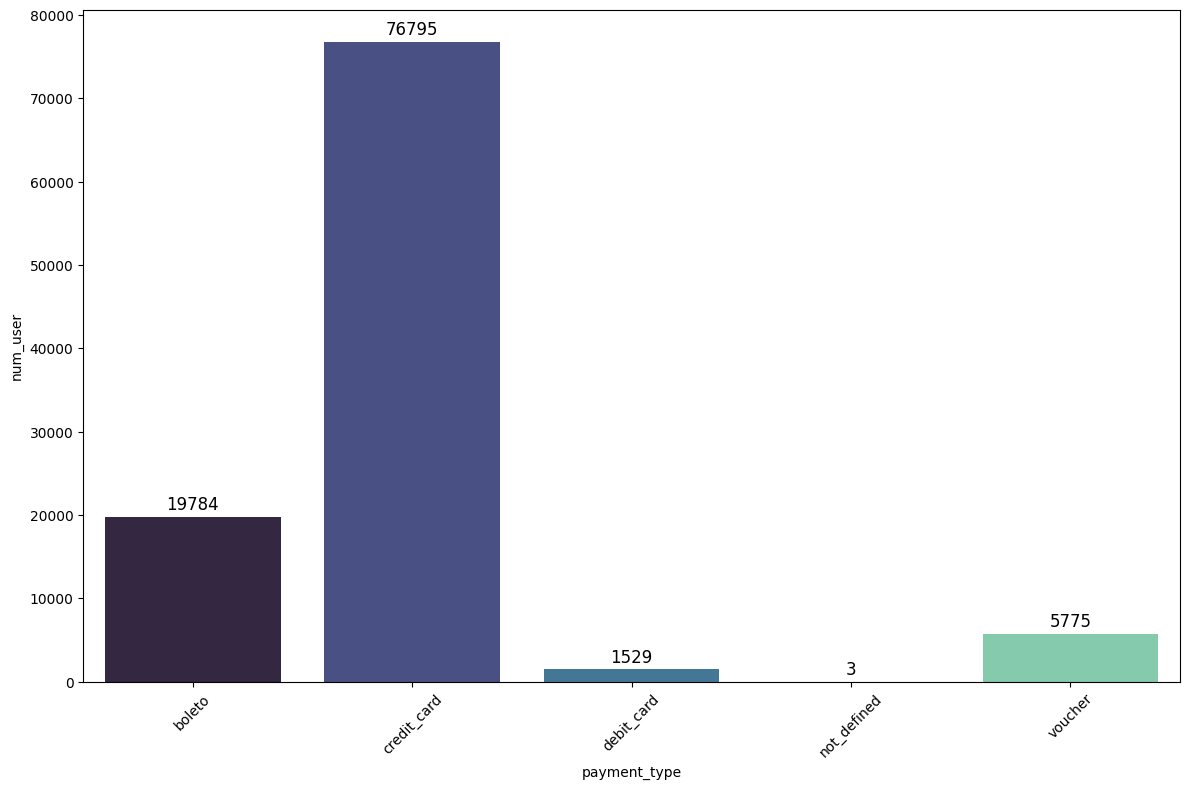

In [26]:
query = """
SELECT payment_type, COUNT(*) num_user
FROM payments
GROUP BY 1
"""
bar_chart(read(query), 'payment_type', 'num_user')

In [34]:
read('select shipping_limit_date from order_items limit 5')

,shipping_limit_date
0,2017-09-19
1,2017-05-03
2,2018-01-18
3,2018-08-15
4,2017-02-13


In [59]:
q = """
SELECT delivered_status, COUNT(1) num_status
FROM
    (SELECT 
        order_delivered_customer_date delivered, 
        order_estimated_delivery_date estimated, 
    CASE
        WHEN order_delivered_customer_date < order_estimated_delivery_date THEN 'faster'
        WHEN order_delivered_customer_date > order_estimated_delivery_date THEN 'late'
        ELSE 'on-time'
    END AS delivered_status
    FROM orders
    WHERE order_status = 'delivered')
GROUP BY 1
"""
read(q)

,delivered_status,num_status
0,faster,88644
1,late,6534
2,on-time,1300


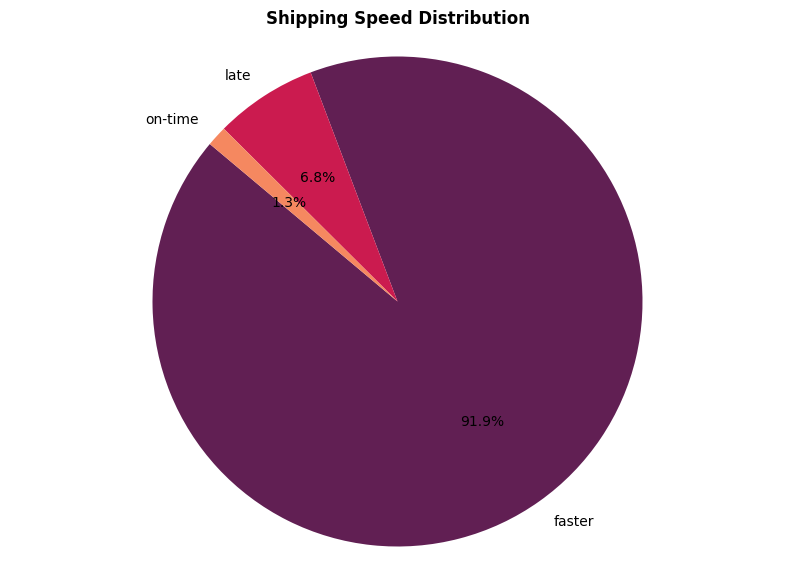

In [60]:
data = read(q)

# Create the pie chart
plt.figure(figsize=(10, 7))
colors = sns.color_palette("rocket", len(data))

plt.pie(data['num_status'], labels=data['delivered_status'], autopct='%1.1f%%', startangle=140, colors=colors)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')
plt.title('Shipping Speed Distribution', fontweight='bold')
plt.show()

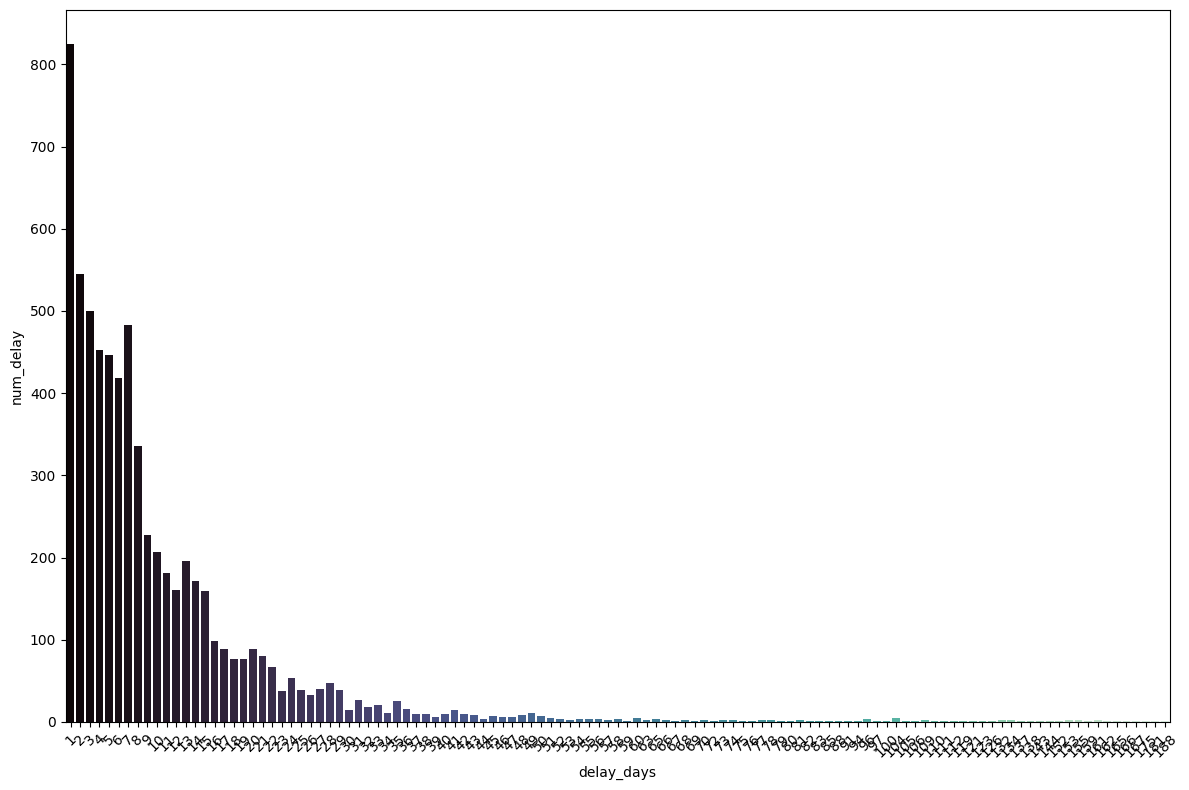

In [73]:
q = '''
SELECT delay_days, COUNT(1) num_delay
FROM
   (SELECT 
      CAST(julianday(order_delivered_customer_date) - julianday(order_estimated_delivery_date) AS INTEGER) AS delay_days
   FROM orders 
   WHERE order_status = "delivered" 
      AND order_estimated_delivery_date < order_delivered_customer_date)
GROUP BY 1
ORDER BY 2 DESC
'''

data = read(q)
bar_chart(data, data['delay_days'], data['num_delay'], False)

In [74]:
read(q)

,delay_days,num_delay
0,1,825
1,2,545
2,3,500
3,7,483
4,4,453
...,...,...
110,75,1
111,72,1
112,69,1
113,67,1


In [95]:
read('''
SELECT 
    order_id, 
    COUNT(DISTINCT seller_id) AS seller_count
FROM 
    order_items
GROUP BY 
    order_id
HAVING 
    COUNT(DISTINCT seller_id) > 1;
''')

,order_id,seller_count
0,002f98c0f7efd42638ed6100ca699b42,2
1,00bcee890eba57a9767c7b5ca12d3a1b,2
2,01144cadcf64b6427f0a6580a3033220,2
3,013a98b3a668bcef05b98898177f6923,2
4,014405982914c2cde2796ddcf0b8703d,2
...,...,...
1273,feded510efe2a76dd134d8533af626f9,2
1274,feea1134dca132388da564d8f026a2ca,2
1275,ff00a56fe9475a175cd651d77c707a09,2
1276,ff2a353ee8dfd97ba95c73cca4ed2636,2


In [94]:
read("""
SELECT 
    s.seller_city,
    c.customer_city,
    CAST(julianday(o.order_delivered_customer_date) - julianday(o.order_estimated_delivery_date) AS INTEGER) AS delay_days
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
JOIN seller s ON oi.seller_id = s.seller_id
""")

,seller_city,customer_city,delay_days
0,maua,sao paulo,-8.0
1,belo horizonte,barreiras,-6.0
2,guariba,vianopolis,-18.0
3,belo horizonte,sao goncalo do amarante,-13.0
4,mogi das cruzes,santo andre,-10.0
...,...,...,...
112645,tupa,praia grande,-2.0
112646,sao paulo,nova vicosa,-6.0
112647,ilicinea,japuiba,-21.0
112648,ilicinea,japuiba,-21.0


In [23]:
q = '''
SELECT AVG(delay_days) avg_delay
FROM
   (SELECT 
      CAST(julianday(order_delivered_customer_date) - julianday(order_estimated_delivery_date) AS INTEGER) AS delay_days
   FROM orders 
   WHERE order_status = "delivered" 
      AND order_estimated_delivery_date < order_delivered_customer_date)
'''

df = read(q)
print(f'Average: {df["avg_delay"][0]}')

Average: 10.620140801958984


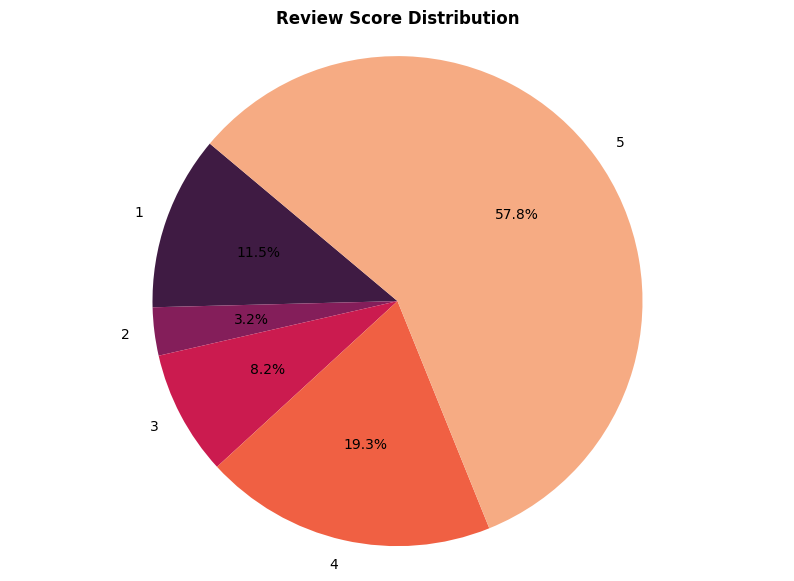

In [86]:
data = read("""
SELECT review_score, COUNT(1) num_review
FROM reviews
GROUP BY 1
""")

# Create the pie chart
plt.figure(figsize=(10, 7))
colors = sns.color_palette("rocket", len(data))

plt.pie(data['num_review'], labels=data['review_score'], autopct='%1.1f%%', startangle=140, colors=colors)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')
plt.title('Review Score Distribution', fontweight='bold')
plt.show()

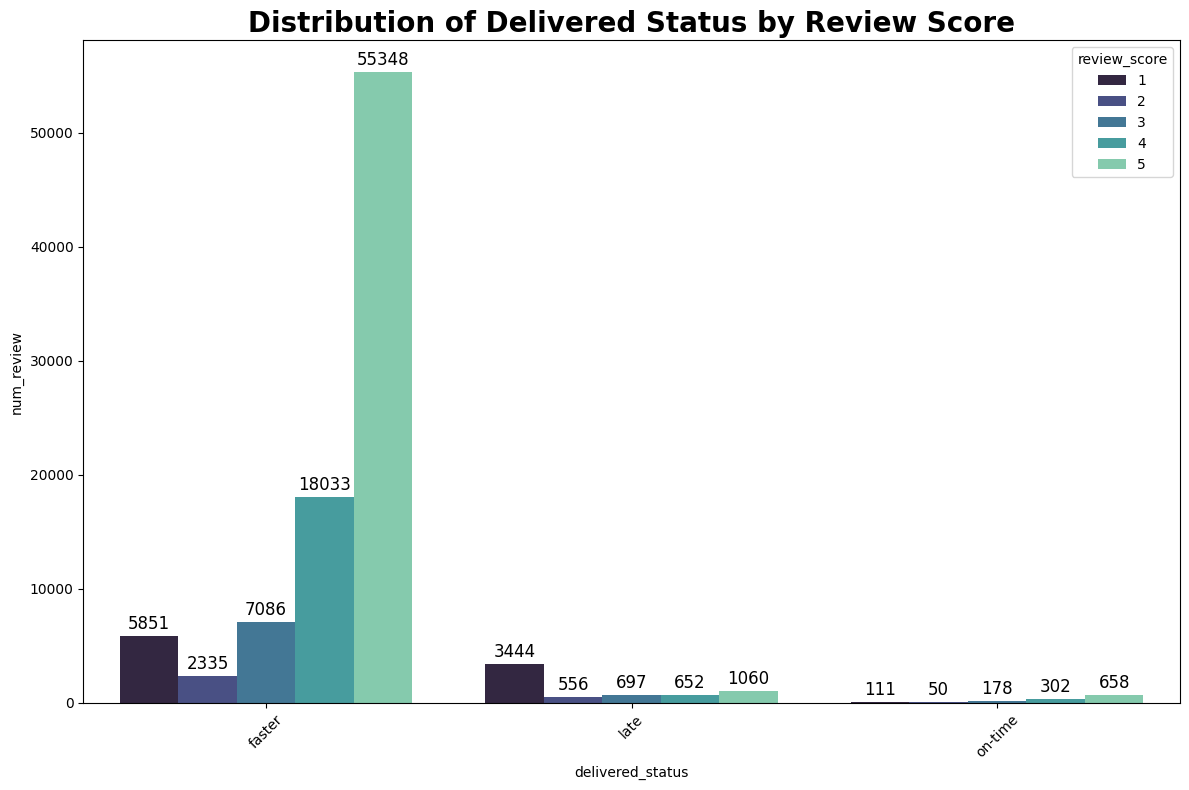

In [92]:
data = read("""
WITH status AS
    (SELECT 
        order_id,
    CASE
        WHEN order_delivered_customer_date < order_estimated_delivery_date THEN 'faster'
        WHEN order_delivered_customer_date > order_estimated_delivery_date THEN 'late'
        ELSE 'on-time'
    END AS delivered_status
    FROM orders
    WHERE order_status = 'delivered')   
SELECT 
    s.delivered_status,
    r.review_score,
    COUNT(1) num_review
FROM reviews r
JOIN status s
    ON r.order_id = s.order_id
GROUP BY 1, 2
""")

bar_chart(data, 'delivered_status', 'num_review', True, 'review_score', 'Distribution of Delivered Status by Review Score')

# Prepare Data for Modeling

In [3]:
def read(query):
    cur.execute(query)
    rows = cur.fetchall()
    
    # get column name from the query
    columns = [description[0] for description in cur.description]

    # create dataframe from the query
    df = pd.DataFrame(rows, columns=columns)
    return df

In [4]:
# prepare.csv built in analisis.sql
df1 = pd.read_csv('data\prepare.csv')

In [5]:
df2 = read('''
SELECT 
    c.customer_unique_id,
    c.customer_id,
    c.customer_state,
    o.order_purchase_timestamp,
    COUNT(*) AS num_orders
FROM customers c
JOIN orders o ON o.customer_id = c.customer_id
GROUP BY 1, 2, 3;
''')

df2.head()

,customer_unique_id,customer_id,customer_state,order_purchase_timestamp,num_orders
0,0000366f3b9a7992bf8c76cfdf3221e2,fadbb3709178fc513abc1b2670aa1ad2,SP,2018-05-10,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4cb282e167ae9234755102258dd52ee8,SP,2018-05-07,1
2,0000f46a3911fa3c0805444483337064,9b3932a6253894a02c1df9d19004239f,SC,2017-03-10,1
3,0000f6ccb0745a6a4b88665a16c9f078,914991f0c02ef0843c0e7010c819d642,PA,2017-10-12,1
4,0004aac84e0df4da2b147fca70cf8255,47227568b10f5f58a524a75507e6992c,SP,2017-11-14,1


In [6]:
df2['order_purchase_timestamp'] = pd.to_datetime(df2['order_purchase_timestamp'], errors='coerce').dt.date
df2 = df2.sort_values('order_purchase_timestamp')
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99441 entries, 71517 to 52747
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_unique_id        99441 non-null  object
 1   customer_id               99441 non-null  object
 2   customer_state            99441 non-null  object
 3   order_purchase_timestamp  99441 non-null  object
 4   num_orders                99441 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 4.6+ MB


In [7]:
df1.head()

,customer_id,order_status,delay_days,price,num_products,freight_value,payment_type,payment_sequential,payment_installments,payment_value,review_score
0,890c32556be4937da98d2f7a73452c6a,delivered,11,585.65,1,18.85,credit_card,1.0,10.0,604.50,5.0
1,a22b5e829ec1ca245de827b70b0fd334,delivered,7,329.00,1,60.31,credit_card,1.0,4.0,389.31,5.0
2,c623bda1dea517d87d913ae3260a32d3,delivered,12,99.00,1,8.44,credit_card,1.0,4.0,107.44,5.0
3,8fb17055fd54b0e086d5320642721a88,delivered,14,345.00,3,18.69,credit_card,1.0,1.0,401.07,5.0
4,885aa5f046631ec02ead6b2bea798a92,delivered,8,89.49,1,8.37,debit_card,1.0,1.0,97.86,5.0


In [8]:
enc1 = pd.get_dummies(df1['order_status'], prefix='status')
enc2 = pd.get_dummies(df1['payment_type'], prefix='type')

df1 = pd.concat([df1, enc1, enc2], axis=1)

In [9]:
df1.drop(['order_status', 'payment_type'], axis='columns', inplace=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97466 entries, 0 to 97465
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_id           97466 non-null  object 
 1   delay_days            97466 non-null  int64  
 2   price                 97466 non-null  float64
 3   num_products          97466 non-null  int64  
 4   freight_value         97466 non-null  float64
 5   payment_sequential    97466 non-null  float64
 6   payment_installments  97466 non-null  float64
 7   payment_value         97466 non-null  float64
 8   review_score          97466 non-null  float64
 9   status_approved       97466 non-null  bool   
 10  status_delivered      97466 non-null  bool   
 11  status_invoiced       97466 non-null  bool   
 12  status_processing     97466 non-null  bool   
 13  status_shipped        97466 non-null  bool   
 14  type_boleto           97466 non-null  bool   
 15  type_credit_card   

In [10]:
df = pd.merge(df2, df1, on='customer_id', how='outer')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_unique_id        99441 non-null  object 
 1   customer_id               99441 non-null  object 
 2   customer_state            99441 non-null  object 
 3   order_purchase_timestamp  99441 non-null  object 
 4   num_orders                99441 non-null  int64  
 5   delay_days                97466 non-null  float64
 6   price                     97466 non-null  float64
 7   num_products              97466 non-null  float64
 8   freight_value             97466 non-null  float64
 9   payment_sequential        97466 non-null  float64
 10  payment_installments      97466 non-null  float64
 11  payment_value             97466 non-null  float64
 12  review_score              97466 non-null  float64
 13  status_approved           97466 non-null  object 
 14  status

In [11]:
df = df.drop('customer_id', axis=1)
df.head()

,customer_unique_id,customer_state,order_purchase_timestamp,num_orders,delay_days,price,num_products,freight_value,payment_sequential,payment_installments,...,review_score,status_approved,status_delivered,status_invoiced,status_processing,status_shipped,type_boleto,type_credit_card,type_debit_card,type_voucher
0,b7d76e111c89f7ebf14761390f0f7d17,RR,2016-09-04,1,0.0,72.89,2.0,31.67,1.0,1.0,...,1.0,False,False,False,False,True,False,True,False,False
1,4854e9b3feff728c13ee5fc7d1547e92,RS,2016-09-05,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,009b0127b727ab0ba422f6d9604487c7,SP,2016-09-13,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,830d5b7aaa3b6f1e9ad63703bec97d23,SP,2016-09-15,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0eb1ee9dba87f5b36b4613a65074337c,SP,2016-10-02,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Grouping by customer_unique_id
grouped_df = df.groupby('customer_unique_id').agg({
    'customer_state': 'first',
    'order_purchase_timestamp': 'last',
    'num_orders': 'sum',             
    'delay_days': 'mean',             
    'price': 'mean',                 
    'num_products': 'mean',           
    'freight_value': 'mean',         
    'payment_sequential': 'mean',     
    'payment_installments': 'mean',   
    'payment_value': 'mean',          
    'review_score': 'mean',          
    'status_approved': 'sum',       
    'status_delivered': 'sum',     
    'status_invoiced': 'sum',       
    'status_processing': 'sum',    
    'status_shipped': 'sum',        
    'type_boleto': 'sum',           
    'type_credit_card': 'sum',     
    'type_debit_card': 'sum',       
    'type_voucher': 'sum'           
}).reset_index()

# shhow result
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_unique_id        96096 non-null  object 
 1   customer_state            96096 non-null  object 
 2   order_purchase_timestamp  96096 non-null  object 
 3   num_orders                96096 non-null  int64  
 4   delay_days                94298 non-null  float64
 5   price                     94298 non-null  float64
 6   num_products              94298 non-null  float64
 7   freight_value             94298 non-null  float64
 8   payment_sequential        94298 non-null  float64
 9   payment_installments      94298 non-null  float64
 10  payment_value             94298 non-null  float64
 11  review_score              94298 non-null  float64
 12  status_approved           96096 non-null  object 
 13  status_delivered          96096 non-null  object 
 14  status

# Data Preprocessing

## Handling Missing Value and Unnecessary Feature

In [13]:
grouped_df.isna().sum()

customer_unique_id             0
customer_state                 0
order_purchase_timestamp       0
num_orders                     0
delay_days                  1798
price                       1798
num_products                1798
freight_value               1798
payment_sequential          1798
payment_installments        1798
payment_value               1798
review_score                1798
status_approved                0
status_delivered               0
status_invoiced                0
status_processing              0
status_shipped                 0
type_boleto                    0
type_credit_card               0
type_debit_card                0
type_voucher                   0
dtype: int64

In [14]:
data = grouped_df.dropna()
data = data.drop(columns='customer_unique_id', axis=1)

In [15]:
le = LabelEncoder()
data['customer_state'] = le.fit_transform(data['customer_state'])

## Change Data Type

In [16]:
col = ['status_approved', 'status_delivered', 'status_invoiced', 'status_processing', 'status_shipped', 'type_boleto', 'type_credit_card', 'type_debit_card', 'type_voucher']

for i in col:
    data[i] = np.where(data[i] > 0, True, False)

data.head()

,customer_state,order_purchase_timestamp,num_orders,delay_days,price,num_products,freight_value,payment_sequential,payment_installments,payment_value,review_score,status_approved,status_delivered,status_invoiced,status_processing,status_shipped,type_boleto,type_credit_card,type_debit_card,type_voucher
0,25,2018-05-10,1,5.0,129.90,1.0,12.00,1.0,8.0,141.90,5.0,False,True,False,False,False,False,True,False,False
1,25,2018-05-07,1,5.0,18.90,1.0,8.29,1.0,1.0,27.19,4.0,False,True,False,False,False,False,True,False,False
2,23,2017-03-10,1,2.0,69.00,1.0,17.22,1.0,8.0,86.22,3.0,False,True,False,False,False,False,True,False,False
3,13,2017-10-12,1,12.0,25.99,1.0,17.63,1.0,4.0,43.62,4.0,False,True,False,False,False,False,True,False,False
4,25,2017-11-14,1,8.0,180.00,1.0,16.89,1.0,6.0,196.89,5.0,False,True,False,False,False,False,True,False,False


In [17]:
data[col].describe()

,status_approved,status_delivered,status_invoiced,status_processing,status_shipped,type_boleto,type_credit_card,type_debit_card,type_voucher
count,94298,94298,94298,94298,94298,94298,94298,94298,94298
unique,2,2,2,2,2,2,2,2,2
top,False,True,False,False,False,False,True,False,False
freq,94296,92754,93991,94003,93274,75382,72741,92805,92825


## Handling Outliers

In [18]:
data['customer_state'] = data['customer_state'].astype('object')
num = data.select_dtypes(include=['float', 'int']).columns

C:\Users\Lutfi Kurrotaeni\AppData\Local\Temp\ipykernel_12404\2030749050.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Lutfi Kurrotaeni\AppData\Local\Temp\ipykernel_12404\2030749050.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Lutfi Kurrotaeni\AppData\Local\Temp\ipykernel_12404\2030749050.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Lutfi Kurrotaeni\AppData\Local\Temp\ipykernel_12404\2030749050.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Lutfi Kurrotaeni\AppData\Local\Temp\ipykernel_12404\2030749050.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Lutfi Kurrotaeni\AppData\Local\Temp\ipykernel_12404\2030749050.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Lutfi Kurrotaeni\AppData\Local\Temp\ipykernel_12404\2030749050.py:4: UserWarning: The

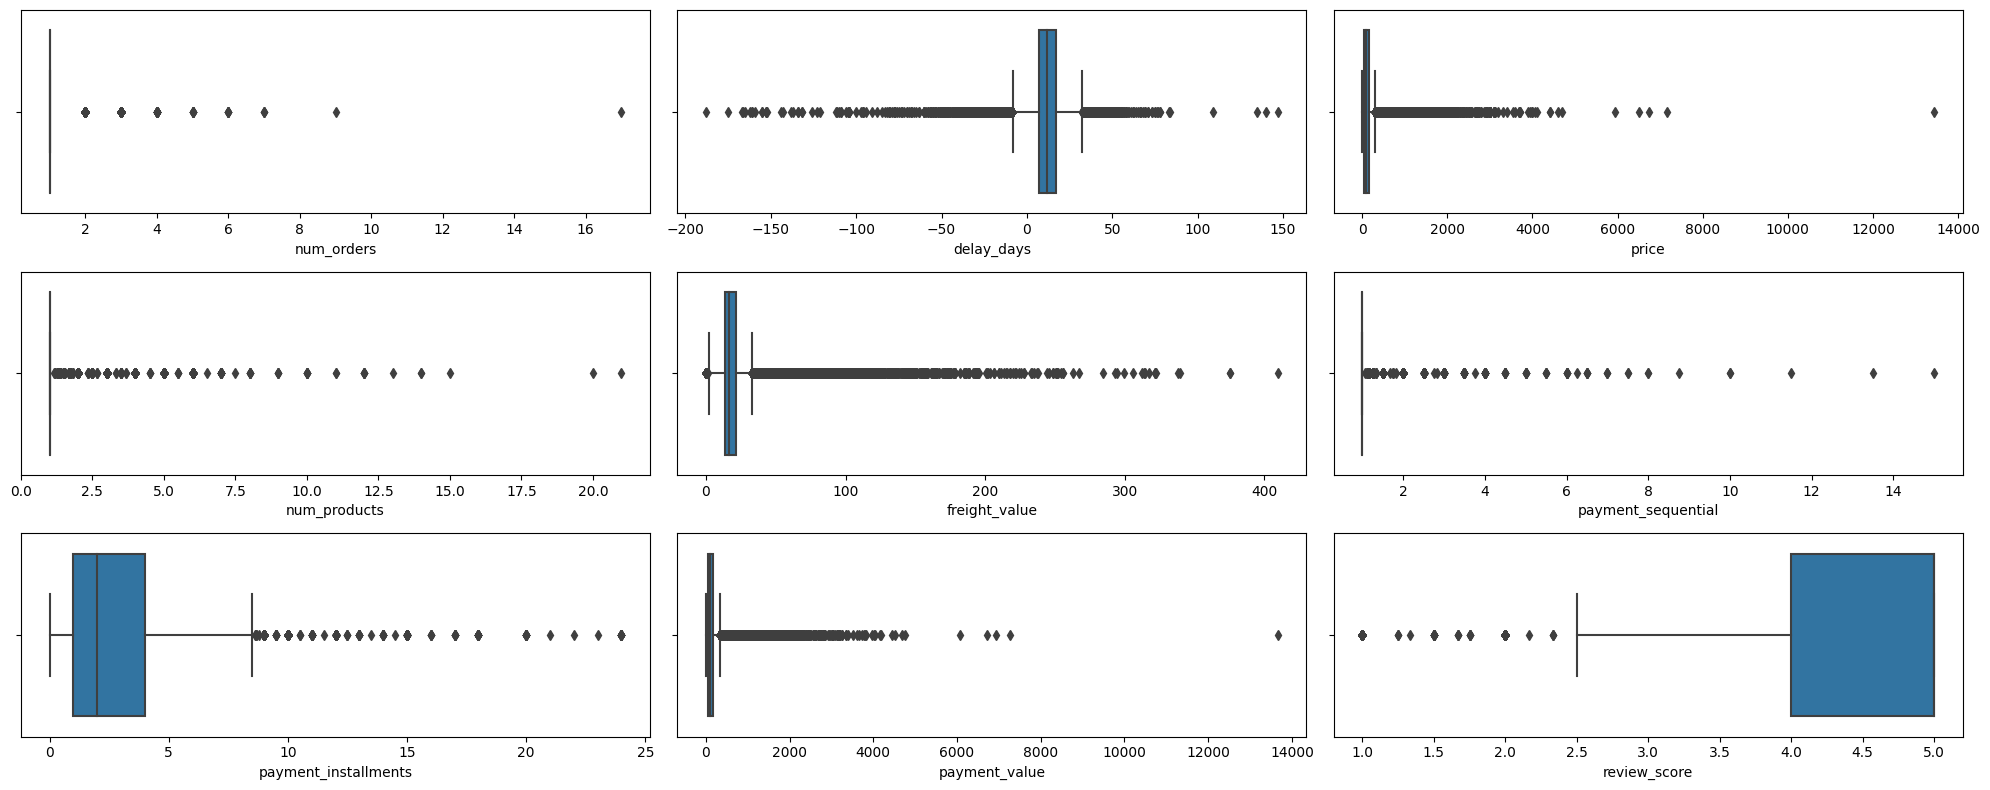

In [19]:
for i in range(len(num)):
    plt.subplot(3, 3, i+1)
    sns.boxplot(data=data, x=num[i])
    plt.tight_layout()

plt.show()

In [20]:
data.describe()

,num_orders,delay_days,price,num_products,freight_value,payment_sequential,payment_installments,payment_value,review_score
count,94298.000000,94298.000000,94298.000000,94298.000000,94298.000000,94298.000000,94298.000000,94298.000000,94298.000000
mean,1.035282,11.684962,137.681687,1.138030,20.227354,1.022815,2.900556,157.884616,4.114228
std,0.215904,10.096673,208.908287,0.521031,15.809079,0.189181,2.675479,216.038123,1.315897
min,1.000000,-188.000000,0.850000,1.000000,0.000000,1.000000,0.000000,1.856818,1.000000
25%,1.000000,7.000000,46.000000,1.000000,13.370000,1.000000,1.000000,60.750000,4.000000
50%,1.000000,12.000000,87.000000,1.000000,16.410000,1.000000,2.000000,103.635000,5.000000
75%,1.000000,17.000000,149.900000,1.000000,21.220000,1.000000,4.000000,174.810000,5.000000
max,17.000000,147.000000,13440.000000,21.000000,409.680000,15.000000,24.000000,13664.080000,5.000000


In [21]:
data[data['num_products'] > 2]['num_products'].mean()

3.7886762360446573

In [22]:
avg_prod = data[data['num_products'] > 2]['num_products'].mean() + 1
avg_seq = data[data['payment_sequential'] > 5]['payment_sequential'].mean()

data['num_products'] = np.where(data['num_products'] > avg_prod, avg_prod, data['num_products'])
data['delay_days'] = data['delay_days'].apply(lambda x: max(0, x))
data['payment_sequential'] = np.where(data['payment_sequential'] > avg_seq, avg_seq, data['payment_sequential'])

In [23]:
def IQR(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    data = np.where(data > Q3 + 1.5 * IQR, Q3 + 1.5 * IQR, data)
    data = np.where(data < Q1 - 1.5 * IQR, Q1 - 1.5 * IQR, data)

    return data

In [24]:
cols = ['delay_days', 'price', 'freight_value', 'payment_installments', 'payment_value']

for i in cols:
    data[i] = IQR(data[i])

In [25]:
data.describe()

,num_orders,delay_days,price,num_products,freight_value,payment_sequential,payment_installments,payment_value,review_score
count,94298.000000,94298.000000,94298.000000,94298.000000,94298.000000,94298.000000,94298.000000,94298.000000,94298.000000
mean,1.035282,12.250383,111.556242,1.132900,17.993656,1.022548,2.803255,131.747291,4.114228
std,0.215904,7.592173,85.305844,0.462863,7.230596,0.176121,2.407326,93.051076,1.315897
min,1.000000,0.000000,0.850000,1.000000,1.595000,1.000000,0.000000,1.856818,1.000000
25%,1.000000,7.000000,46.000000,1.000000,13.370000,1.000000,1.000000,60.750000,4.000000
50%,1.000000,12.000000,87.000000,1.000000,16.410000,1.000000,2.000000,103.635000,5.000000
75%,1.000000,17.000000,149.900000,1.000000,21.220000,1.000000,4.000000,174.810000,5.000000
max,17.000000,32.000000,305.750000,4.788676,32.995000,7.450000,8.500000,345.900000,5.000000


C:\Users\Lutfi Kurrotaeni\AppData\Local\Temp\ipykernel_12404\2030749050.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Lutfi Kurrotaeni\AppData\Local\Temp\ipykernel_12404\2030749050.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Lutfi Kurrotaeni\AppData\Local\Temp\ipykernel_12404\2030749050.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Lutfi Kurrotaeni\AppData\Local\Temp\ipykernel_12404\2030749050.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Lutfi Kurrotaeni\AppData\Local\Temp\ipykernel_12404\2030749050.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Lutfi Kurrotaeni\AppData\Local\Temp\ipykernel_12404\2030749050.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Lutfi Kurrotaeni\AppData\Local\Temp\ipykernel_12404\2030749050.py:4: UserWarning: The

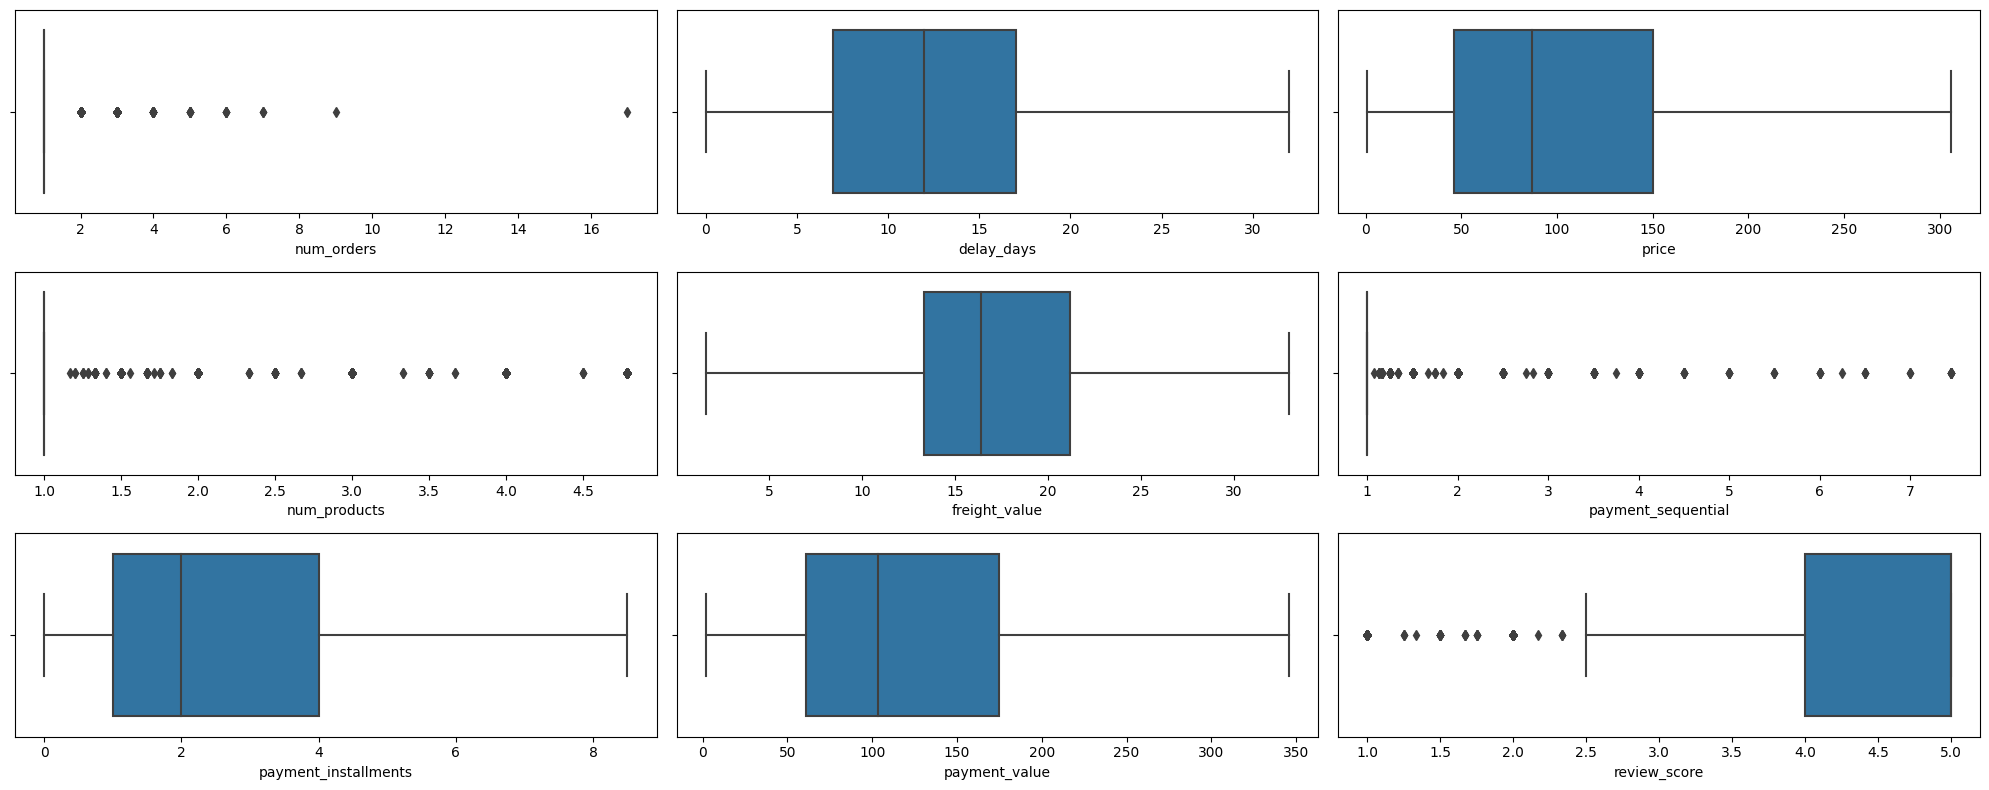

In [26]:
for i in range(len(num)):
    plt.subplot(3, 3, i+1)
    sns.boxplot(data=data, x=num[i])
    plt.tight_layout()

plt.show()

## Split Data

In [27]:
from sklearn.model_selection import train_test_split

data['customer_state'] = data['customer_state'].astype('int')

df_x = data[data['num_orders'] == 1]
df_y = data[data['num_orders'] > 1]

split = int(len(df_x) / 3)

df_train = df_x.iloc[:split]

In [28]:
df_train.describe()

,customer_state,num_orders,delay_days,price,num_products,freight_value,payment_sequential,payment_installments,payment_value,review_score
count,30439.000000,30439.0,30439.000000,30439.000000,30439.000000,30439.000000,30439.000000,30439.000000,30439.000000,30439.000000
mean,18.679819,1.0,12.203456,111.775392,1.127062,17.987944,1.021461,2.787649,131.999745,4.110467
std,7.065145,0.0,7.628499,85.476908,0.457138,7.208639,0.178929,2.407214,93.142013,1.324555
min,0.000000,1.0,0.000000,2.200000,1.000000,1.595000,1.000000,1.000000,1.856818,1.000000
25%,12.000000,1.0,7.000000,47.125000,1.000000,13.430000,1.000000,1.000000,60.780000,4.000000
50%,22.000000,1.0,12.000000,88.000000,1.000000,16.445000,1.000000,2.000000,103.830000,5.000000
75%,25.000000,1.0,17.000000,149.900000,1.000000,21.220000,1.000000,4.000000,174.790000,5.000000
max,26.000000,1.0,32.000000,305.750000,4.788676,32.995000,7.450000,8.500000,345.900000,5.000000


In [29]:
df_y.describe()

,customer_state,num_orders,delay_days,price,num_products,freight_value,payment_sequential,payment_installments,payment_value,review_score
count,2980.000000,2980.000000,2980.000000,2980.000000,2980.000000,2980.000000,2980.000000,2980.000000,2980.000000,2980.000000
mean,18.909396,2.116443,12.643820,111.325284,1.201077,18.028918,1.030586,3.207164,131.344375,4.139077
std,6.957540,0.517759,6.694498,77.513825,0.492405,6.933829,0.215768,2.448051,84.803175,1.139776
min,0.000000,2.000000,0.000000,5.990000,1.000000,1.595000,1.000000,1.000000,6.848036,1.000000
25%,13.000000,2.000000,8.500000,54.900000,1.000000,13.344167,1.000000,1.000000,69.722500,3.500000
50%,22.000000,2.000000,12.500000,88.912500,1.000000,16.490000,1.000000,2.000000,106.517500,4.500000
75%,25.000000,2.000000,16.500000,146.100000,1.000000,20.888125,1.000000,5.000000,170.142500,5.000000
max,26.000000,17.000000,32.000000,305.750000,4.788676,32.995000,7.450000,8.500000,345.900000,5.000000


In [30]:
X = pd.concat([df_train, df_y], axis=0)
X.sample(5)

,customer_state,order_purchase_timestamp,num_orders,delay_days,price,num_products,freight_value,payment_sequential,payment_installments,payment_value,review_score,status_approved,status_delivered,status_invoiced,status_processing,status_shipped,type_boleto,type_credit_card,type_debit_card,type_voucher
2236,18,2017-11-10,1,13.0,41.560,1.0,15.100,1.0,1.0,56.660,5.0,False,True,False,False,False,True,False,False,False
81603,18,2017-05-15,2,15.5,121.355,1.0,17.010,1.0,1.0,138.365,2.0,False,True,False,False,False,False,False,False,True
17710,25,2018-06-17,1,7.0,229.990,1.0,9.770,1.0,4.0,239.760,1.0,False,True,False,False,False,False,True,False,False
8053,5,2017-12-05,1,19.0,99.980,1.0,19.240,1.0,1.0,119.220,5.0,False,True,False,False,False,False,False,False,True
26427,10,2018-01-29,1,32.0,79.990,1.0,32.995,1.0,2.0,113.910,4.0,False,True,False,False,False,False,True,False,False


In [31]:
X['churn'] = np.where(X['num_orders'] == 1, True, False)

X = X.drop(columns=['num_orders', 'order_purchase_timestamp'], axis=1)

In [32]:
y = X['churn']
X = X.drop('churn', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [33]:
print(f'Train data has {len(X_train)} rows with {y_train.value_counts()} \n')
print(f'Test data has {len(X_test)} rows with {y_test.value_counts()}')

Train data has 23393 rows with churn
True     21307
False     2086
Name: count, dtype: int64 

Test data has 10026 rows with churn
True     9132
False     894
Name: count, dtype: int64


## Data Normalization

In [34]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Handling Imbalance

In [35]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import TomekLinks

smote = SMOTE(random_state=42)
tl = TomekLinks(n_jobs=-1)

X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print('Before:', y_train.value_counts())
print('\nAfter:', y_resampled.value_counts())

Before: churn
True     21307
False     2086
Name: count, dtype: int64

After: churn
True     21307
False    21307
Name: count, dtype: int64


# Modeling

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_validate

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

In [37]:
models = [
    ('Logistic Regression', LogisticRegression(class_weight='balanced')),
    ('Decision Trees', DecisionTreeClassifier(class_weight='balanced')),
    ('Random Forest', RandomForestClassifier(class_weight='balanced')),
    ('XGBoost', XGBClassifier(random_state=0)),
    ]

In [38]:
def evaluate(X_train, y_train, X_test, y_test):
    results = []

    for (model_name, model) in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy_test = round(accuracy_score(y_test, y_pred) * 100, 2)
        precision_test = round(precision_score(y_test, y_pred) * 100, 2)
        recall_test = round(recall_score(y_test, y_pred) * 100, 2)
        f1score_test = round(f1_score(y_test, y_pred) * 100, 2)

        results.append([model_name, accuracy_test, precision_test, recall_test,  f1score_test])

    results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
    return results_df

In [39]:
evaluate(X_resampled, y_resampled, X_test, y_test)

c:\Users\Lutfi Kurrotaeni\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,73.79,93.19,76.84,84.23
1,Decision Trees,90.09,95.32,93.71,94.51
2,Random Forest,93.61,94.68,98.52,96.56
3,XGBoost,97.14,97.10,99.84,98.45


In [40]:
ratio = len(y_train[y_train == False]) / len(y_train[y_train == True])

model = XGBClassifier(random_state=0, scale_pos_weight=ratio)
model.fit(X_resampled, y_resampled)

y_train_pred = model.predict(X_resampled)
y_test_pred = model.predict(X_test)

accuracy = accuracy_score(y_resampled, y_train_pred)
precision = precision_score(y_resampled, y_train_pred)
recall = recall_score(y_resampled, y_train_pred)
f1 = f1_score(y_resampled, y_train_pred)

print("Model Performance metrics:")
print("------------------------------")
print(f"Train Accuracy: {accuracy:.2f}")
print(f"Train Precision: {precision:.2f}")
print(f"Train Recall: {recall:.2f}")
print(f"Train F1 Score: {f1:.2f}")

print("\nModel Classification report:")
print("------------------------------")
print(classification_report(y_test, y_test_pred))

Model Performance metrics:
------------------------------
Train Accuracy: 0.96
Train Precision: 0.99
Train Recall: 0.92
Train F1 Score: 0.95

Model Classification report:
------------------------------
              precision    recall  f1-score   support

       False       0.42      0.78      0.55       894
        True       0.98      0.89      0.93      9132

    accuracy                           0.88     10026
   macro avg       0.70      0.84      0.74     10026
weighted avg       0.93      0.88      0.90     10026



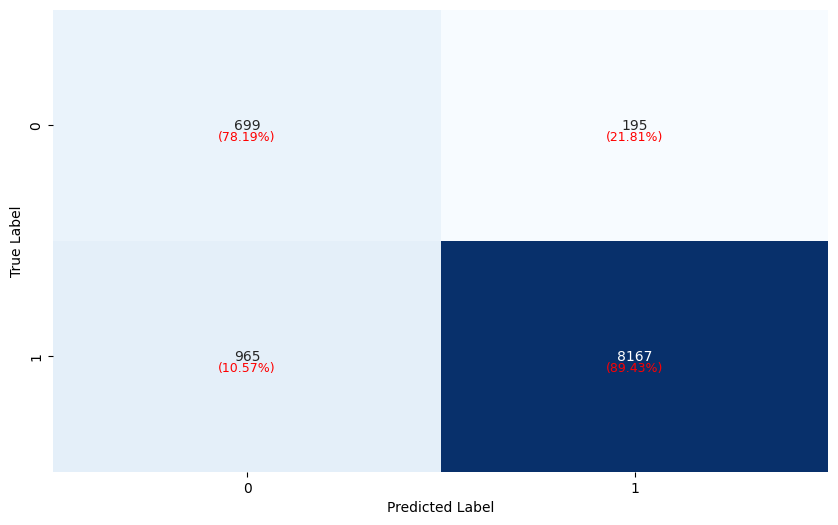

In [41]:
cm = confusion_matrix(y_test, y_test_pred)

cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=model.classes_, yticklabels=model.classes_)

for i in range(len(model.classes_)):
    for j in range(len(model.classes_)):
        text = f"({cm_percent[i, j]*100:.2f}%)"
        plt.text(j + 0.5, i + 0.55, text, ha='center', va='center', color='red', fontsize=9)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [42]:
from sklearn.model_selection import cross_validate

def cross_val_evaluation(model, X, y, cv=5):
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring)
    
    print(f"Cross-Validation (cv={cv}) Results:")
    
    for i in range(cv):
        print(f"Fold {i+1}:")
        print(f"Accuracy: {scores['test_accuracy'][i]:.2f}")
        print(f"Precision: {scores['test_precision'][i]:.2f}")
        print(f"Recall: {scores['test_recall'][i]:.2f}")
        print(f"F1 Score: {scores['test_f1'][i]:.2f} \n")
    
    print("Average Results:")
    print(f"Accuracy: {np.mean(scores['test_accuracy']):.2f} ± {np.std(scores['test_accuracy']):.2f}")
    print(f"Precision: {np.mean(scores['test_precision']):.2f} ± {np.std(scores['test_precision']):.2f}")
    print(f"Recall: {np.mean(scores['test_recall']):.2f} ± {np.std(scores['test_recall']):.2f}")
    print(f"F1 Score: {np.mean(scores['test_f1']):.2f} ± {np.std(scores['test_f1']):.2f}")


In [43]:
cross_val_evaluation(model, X, y)

Cross-Validation (cv=5) Results:
Fold 1:
Accuracy: 0.95
Precision: 0.97
Recall: 0.97
F1 Score: 0.97 

Fold 2:
Accuracy: 0.96
Precision: 0.97
Recall: 0.98
F1 Score: 0.98 

Fold 3:
Accuracy: 0.95
Precision: 0.97
Recall: 0.98
F1 Score: 0.97 

Fold 4:
Accuracy: 0.95
Precision: 0.97
Recall: 0.98
F1 Score: 0.97 

Fold 5:
Accuracy: 0.96
Precision: 0.98
Recall: 0.98
F1 Score: 0.98 

Average Results:
Accuracy: 0.95 ± 0.00
Precision: 0.97 ± 0.00
Recall: 0.98 ± 0.00
F1 Score: 0.97 ± 0.00


# Predict Unlabeled Data

In [44]:
df_valid = df_x.iloc[split:]
df_valid = df_valid.drop(columns=['num_orders', 'order_purchase_timestamp'], axis=1)

df_valid.describe()

,customer_state,delay_days,price,num_products,freight_value,payment_sequential,payment_installments,payment_value,review_score
count,60879.000000,60879.000000,60879.000000,60879.000000,60879.000000,60879.000000,60879.000000,60879.000000,60879.000000
mean,18.598581,12.254587,111.457974,1.132481,17.994786,1.022697,2.791287,131.640789,4.114892
std,7.105030,7.614814,85.584841,0.463958,7.255851,0.172502,2.403695,93.391931,1.319597
min,0.000000,0.000000,0.850000,1.000000,1.595000,1.000000,0.000000,2.410769,1.000000
25%,11.000000,7.000000,45.900000,1.000000,13.370000,1.000000,1.000000,60.090000,4.000000
50%,22.000000,12.000000,86.900000,1.000000,16.390000,1.000000,2.000000,103.460000,5.000000
75%,25.000000,17.000000,149.940000,1.000000,21.250000,1.000000,4.000000,175.080000,5.000000
max,26.000000,32.000000,305.750000,4.788676,32.995000,7.450000,8.500000,345.900000,5.000000


In [45]:
scaled = scaler.transform(df_valid)
out = model.predict(df_valid)

In [46]:
df_valid['label'] = out
df_valid['label'].value_counts()

label
1    59819
0     1060
Name: count, dtype: int64